In [ ]:
#setting up packages/etc for our code to run
!pip install geopandas
!pip install wbdata
!pip install cufflinks
!pip install iso3166

#import iso3166 #iso3166.countries.get('country details')
import wbdata
import cufflinks as cf
import pandas as pd
import numpy as np
import plotly
import matplotlib.pyplot as plt
import seaborn as sns
cf.go_offline()
import geopandas


     |████████████████████████████████| 1.0 MB 8.1 MB/s 
     |████████████████████████████████| 16.7 MB 278 kB/s 
     |████████████████████████████████| 6.3 MB 30.5 MB/s 


In [ ]:
# Start with an empty list of age-ranges and then construct the range we needed for future methods
#simplifies later methods
age_ranges = []
renames = {
    'Males 0004':'Males Ages 00-04',
    'Males 0509':'Males Ages 05-09',
    'Males 1014':'Males Ages 10-14',
    'Males 1519':'Males Ages 15-19',
    'Males 2024':'Males Ages 20-24',
    'Males 2529':'Males Ages 25-29',
    'Males 3034':'Males Ages 30-34',
    'Males 3539':'Males Ages 35-39',
    'Males 4044':'Males Ages 40-44',
    'Males 4549':'Males Ages 45-49',
    'Males 5054':'Males Ages 50-54',
    'Males 5559':'Males Ages 55-59',
    'Males 6064':'Males Ages 60-64',
    'Males 6569':'Males Ages 65-69',
    'Males 7074':'Males Ages 70-74',
    'Males 7579':'Males Ages 75-79',
    'Males 80UP':'Males Ages 80+',
    'Females 0004' : 'Females Ages 00-04',
    'Females 0509':'Females Ages 05-09',
    'Females 1014':'Females Ages 10-14',
    'Females 1519':'FemalesAges 15-19',
    'Females 2024':'Females Ages 20-24',
    'Females 2529':'Females Ages 25-29',
    'Females 3034':'Females Ages 30-34',
    'Females 3539':'Females Ages 35-39',
    'Females 4044':'Females Ages 40-44',
    'Females 4549':'Females Ages 45-49',
    'Females 5054':'Females Ages 50-54',
    'Females 5559':'Females Ages 55-59',
    'Females 6064':'Females Ages 60-64',
    'Females 6569':'Females Ages 65-69',
    'Females 7074':'Females Ages 70-74',
    'Females 7579':'Females Ages 75-79',
    'Females 80UP':'Females Ages 80+',
}
# Ranges top out at 80, and go in five year increments
for i in range(0,80,5):
    age_ranges.append(f"{i:02d}"+f"{i+4:02d}")

age_ranges.append("80UP")
male_variables = {"SP.POP."+age_range+".MA":"Males "+age_range for age_range in age_ranges}
female_variables = {"SP.POP."+age_range+".FE":"Females "+age_range for age_range in age_ranges}

In [ ]:
#Jesus B Soto:
# Give variable for clarity
#Here's an example of the populations we are looking at
variable_labels = {"SP.POP.TOTL":"Russia Population"}

world = wbdata.get_dataframe(variable_labels, country="RUS")

# Date index is of type string; change to integers
world.index = world.index.astype(int)

# Print a few years' data
world.head(30)

,Russia Population
date,
2020,144104080.0
2019,144406261.0
2018,144477859.0
2017,144496739.0
2016,144342397.0
2015,144096870.0
2014,143819667.0
2013,143506995.0
2012,143201721.0


In [ ]:
#First part A: Population Statistics
def format_range(age_range):
  # Helper method for age formatting for API call to retrieve dataframe as illustrated in lecture
  low, high = age_range[0], age_range[1]
  if high > 80:
    formatted_range = [f"{i:02d}"+f"{i+4:02d}" for i in range(low, 80, 5)]
    formatted_range.append("80UP")
  else: 
    formatted_range = [f"{i:02d}"+f"{i+4:02d}" for i in range(low, high, 5)]
  return formatted_range

#included modulo operator in order to format function to be able to take age ranges outside of the increments of 5 years
def population(year, sex, age_range, place):
    start_increment = 0
    end_increment = 0
    age_range = list(age_range)
    if age_range[0] % 5 != 0:
        start_increment = age_range[0] % 5
        age_range[0] = age_range[0] - start_increment
    if age_range[1] % 5 != 0:
        end_increment = age_range[1] % 5
        age_range[1] = age_range[1] + (5 - age_range[1]%5)
    age_range = tuple(age_range)
    formatted_range = format_range(age_range)
    if sex == "Male":
        variables = {"SP.POP."+age_range+".MA":"Male"+age_range for age_range in formatted_range}
    elif sex == "Female":
        variables = {"SP.POP."+age_range+".FE":"Female"+age_range for age_range in formatted_range}
    df = wbdata.get_dataframe(variables, country=place)
    df = df.reset_index()
    df['date'] = df['date'].astype(int)
    result = df[df['date'] ==year]
    fixed_start = result.iloc[0][1:][0]*((5-start_increment)/5)
    fixed_end = (result.iloc[0][1:][len(result.iloc[0][1:])-1])*(end_increment+1)/5
    product = result.iloc[0][1:]
    product[0] = fixed_start
    product[len(product)-1] = fixed_end
    return sum(product)

In [ ]:
#unit test for code above:

assert population(year=2000,sex='Male',age_range=(0,100),place='WLD') > 3e9

In [ ]:
#they'll input region/country as area and year
#should take in an array of countries they want
#input years as [min,max]
def Groups_of_People(Area,years):
    renames = {
    'Males 0004':'Males Ages 00-04',
    'Males 0509':'Males Ages 05-09',
    'Males 1014':'Males Ages 10-14',
    'Males 1519':'Males Ages 15-19',
    'Males 2024':'Males Ages 20-24',
    'Males 2529':'Males Ages 25-29',
    'Males 3034':'Males Ages 30-34',
    'Males 3539':'Males Ages 35-39',
    'Males 4044':'Males Ages 40-44',
    'Males 4549':'Males Ages 45-49',
    'Males 5054':'Males Ages 50-54',
    'Males 5559':'Males Ages 55-59',
    'Males 6064':'Males Ages 60-64',
    'Males 6569':'Males Ages 65-69',
    'Males 7074':'Males Ages 70-74',
    'Males 7579':'Males Ages 75-79',
    'Males 80UP':'Males Ages 80+',
    'Females 0004' : 'Females Ages 00-04',
    'Females 0509':'Females Ages 05-09',
    'Females 1014':'Females Ages 10-14',
    'Females 1519':'FemalesAges 15-19',
    'Females 2024':'Females Ages 20-24',
    'Females 2529':'Females Ages 25-29',
    'Females 3034':'Females Ages 30-34',
    'Females 3539':'Females Ages 35-39',
    'Females 4044':'Females Ages 40-44',
    'Females 4549':'Females Ages 45-49',
    'Females 5054':'Females Ages 50-54',
    'Females 5559':'Females Ages 55-59',
    'Females 6064':'Females Ages 60-64',
    'Females 6569':'Females Ages 65-69',
    'Females 7074':'Females Ages 70-74',
    'Females 7579':'Females Ages 75-79',
    'Females 80UP':'Females Ages 80+',
}
    # Start with an empty list of age-rages
    age_ranges = []
    # Ranges top out at 80, and go in five year increments
    for i in range(0,80,5):
        age_ranges.append(f"{i:02d}"+f"{i+4:02d}")
    age_ranges.append("80UP")
    male_variables = {"SP.POP."+age_range+".MA":"Males "+age_range for age_range in age_ranges}
    female_variables = {"SP.POP."+age_range+".FE":"Females "+age_range for age_range in age_ranges}
    variables = male_variables
    variables.update(female_variables)
    df = wbdata.get_dataframe(variables,country=Area)
    df = df.rename(columns = renames)
    df = df.reset_index()
    df['date'] = df['date'].astype(int)
    df = df[df['date'] <= years[1]]
    df = df[df['date'] >= years[0]]
    if len(Area) > 1:
        df = df.set_index(['country','date'])
    else:#only one figure out 
        df['country'] = Area[0]
        df = df.set_index(['country','date'])
    return df

In [ ]:
#Creating a test for part b
test = Groups_of_People(['USA'],[2010,2019]).reset_index()
test = test.drop(columns = ['country'])
#test = test.set_index('date')
test.loc[0,:]

date                      2019.0
Males Ages 00-04       9996862.0
Males Ages 80+         5125216.0
Males Ages 05-09      10347964.0
Males Ages 10-14      10781682.0
Males Ages 15-19      10812989.0
Males Ages 20-24      11398033.0
Males Ages 25-29      12077266.0
Males Ages 30-34      11486356.0
Males Ages 35-39      10648938.0
Males Ages 40-44      10017138.0
Males Ages 45-49      10007483.0
Males Ages 50-54      10447798.0
Males Ages 55-59      10730282.0
Males Ages 60-64       9890799.0
Males Ages 65-69       8243728.0
Males Ages 70-74       6342514.0
Males Ages 75-79       4107578.0
Females Ages 00-04     9563448.0
Females Ages 80+       7761346.0
Females Ages 05-09     9894472.0
Females Ages 10-14    10318554.0
FemalesAges 15-19     10390150.0
Females Ages 20-24    10987824.0
Females Ages 25-29    11612802.0
Females Ages 30-34    11166357.0
Females Ages 35-39    10580188.0
Females Ages 40-44    10089427.0
Females Ages 45-49    10084408.0
Females Ages 50-54    10372061.0
Females Ag

In [ ]:
#Part B (Population Pyramids)
#only takes a dataframe with just columns of age group and that's it
#must be indexed not by date or country (use default index, or reset index prior to use)
#Will need to manually reset the x axis labels to match the population of the country of interest
import plotly.offline as py
import plotly.graph_objs as go
import pandas as pd
import numpy as np
def pyramid(df):
    py.init_notebook_mode(connected=True)

    layout = go.Layout(barmode='overlay',
                       yaxis=go.layout.YAxis(range=[0, 90], title='Age'),
                       xaxis=go.layout.XAxis(title='Number'))


    bins = [go.Bar(x = df.filter(regex="Male").values,
                   y = [int(s[:2])+1 for s in age_ranges],
                   orientation='h',
                   name='Men',
                   marker=dict(color='blue'),
                   hoverinfo='skip'
                   ),

            go.Bar(x = -df.filter(regex="Female").values,
                   y=[int(s[:2])+1 for s in age_ranges],
                   orientation='h',
                   name='Women',
                   marker=dict(color='orange'),
                   hoverinfo='skip',
                   )
            ]
    fig = go.Figure(dict(data = bins, layout = layout))
    fig.update_xaxes(tickvals = [-10000000,-5000000,0,5000000,10000000])
    fig.update_xaxes(ticktext = ['10M','5M','0','5M','10M'])
    fig.show()

In [ ]:
#testing part B
pyramid(test.loc[0,:])

In [ ]:
#formatting our test dataframe to run 
test['date'] = test['date'].astype(str)
test = test.set_index('date')

In [ ]:
#setting up a test for animated pyramids and to show Georgia stuff
georgia = Groups_of_People(['GEO'],[1961,2020])
georgia = georgia.reset_index()
georgia['date'] = georgia['date'].astype(str)
georgia = georgia.set_index('date')
georgia = georgia.drop(columns = ['country'])

NameError: ignored

In [ ]:
# C animated pyramid
#animated pyramid Part C Deliverable
#df fed into animated pyramid must be indexed by date and columns must be different age/sex ranges
#need to make the year range the range of years in the dataset manually
#the date column must be a string type, not an int or float
def animated_pyramid(df):
    def pyramid_builder(year):
        py.init_notebook_mode(connected=True)
        layout = go.Layout(barmode='overlay',
                   yaxis=go.layout.YAxis(range=[0, 90], title='Age'),
                   xaxis=go.layout.XAxis(title='Number'))
        bins = [go.Bar(x = df.loc[str(year),:].filter(regex="Male").values,
               y = [int(s[:2])+1 for s in age_ranges],
               orientation='h',
               name='Men',
               marker=dict(color='blue'),
               hoverinfo='skip'
               ),
        go.Bar(x = -df.loc[str(year),:].filter(regex="Female").values,
               y=[int(s[:2])+1 for s in age_ranges],
               orientation='h',
               name='Women',
               marker=dict(color='orange'),
               hoverinfo='skip',
               )
        ]
        fig = go.Figure(dict(data = bins, layout = layout))
        fig.update_xaxes(tickvals = [-150000,-100000,50000,0,50000,100000,150000])
        fig.update_xaxes(ticktext = ['150K','100K','50K','0','50K','100K','150K'])
        fig.show()
        #py.iplot(dict(data=bins, layout=layout))
    ipywidgets.interact(pyramid_builder, year=(1961, 2020, 1))

In [ ]:
#importing package to make a slider
#year range must be within the range of our dataframe, set in the cell above
import ipywidgets
from ipywidgets import interactive, HBox, VBox
animated_pyramid(georgia)

interactive(children=(IntSlider(value=1989, description='year', max=2018, min=1961), Output()), _dom_classes=(…

In [ ]:
#Deliverable C (Population Maps) (Possibly Delete)
!pip install geopandas
!pip install wbdata
!pip install cufflinks
!pip install iso3166

import iso3166 #iso3166.countries.get('country details')
import wbdata
import cufflinks as cf
import pandas as pd
import numpy as np
import plotly
import matplotlib.pyplot as plt
import seaborn as sns
cf.go_offline()
import geopandas

In [ ]:
#A function that draws a geopanda graph, accepting a query_dictionary, the year and the title as arguments
#countries_ussr = ['Armenia', 'Azerbaijan', 'Belarus', 'Estonia', 'Georgia', 'Kazakhstan', 'Kyrgyz Republic', 'Latvia', 'Lithuania', 'Moldova', 'Russia', 'Tajikistan', 'Turkmenistan', 'Ukraine', 'Uzbekistan']
#countries_iso3166 = ['ARM', 'AZE', 'BLR', 'EST', 'GEO','KAZ', 'KGZ', 'LVA', 'LTU', 'MDA', 'RUS', 'TJK', 'TKM', 'UKR', 'UZB' ]

#countries: Armenia', 'Azerbaijan', 'Belarus', 'Estonia', 'Georgia', 'Kazakhstan', 'Kyrgyz Republic', 'Latvia', 'Lithuania', 'Moldova', 'Russia', 'Tajikistan', 'Turkmenistan', 'Ukraine', 'Uzbekistan'

def geopand_ussr(indi_dict, year, title):
    countries_ussr = ['Armenia', 'Azerbaijan', 'Belarus', 'Estonia', 'Georgia','Kyrgyzstan', 'Kazakhstan', 'Latvia', 'Lithuania', 'Moldova', 'Russia','Tajikistan', 'Turkmenistan', 'Ukraine', 'Uzbekistan']
    countries_iso3166 = ['ARM', 'AZE', 'BLR', 'EST', 'GEO','KAZ', 'KGZ', 'LVA', 'LTU', 'MDA', 'RUS','TJK', 'TKM', 'UKR', 'UZB']
    
    df = wbdata.get_dataframe(indicators=indi_dict, country=countries_iso3166)
    df.reset_index(inplace=True)
    df['date'] = df['date'].astype(int)
    df = df[df['date'] == year]
    df = df.sort_values(by=['country'])

    world = geopandas.read_file(geopandas.datasets.get_path('naturalearth_lowres'))
    world = world[world['name'].isin(countries_ussr)]
    world = world.sort_values(by=['name'])
    world['data_column'] = df['data_column'].values

    graph = world.plot('data_column', cmap='Spectral', figsize=(20,20), legend=True, legend_kwds={'shrink': 0.75}, aspect= 'auto', edgecolor= 'black')
    
    graph.set_xlim(right = 185)
    graph.set_xlim(left = -1)
    
    graph.set_title(title, size=22, pad=20);

    world.apply(lambda x: graph.annotate(text=x['name'], xy=x.geometry.centroid.coords[0], 
                                         ha='center'),axis=1);
    


TypeError: ignored

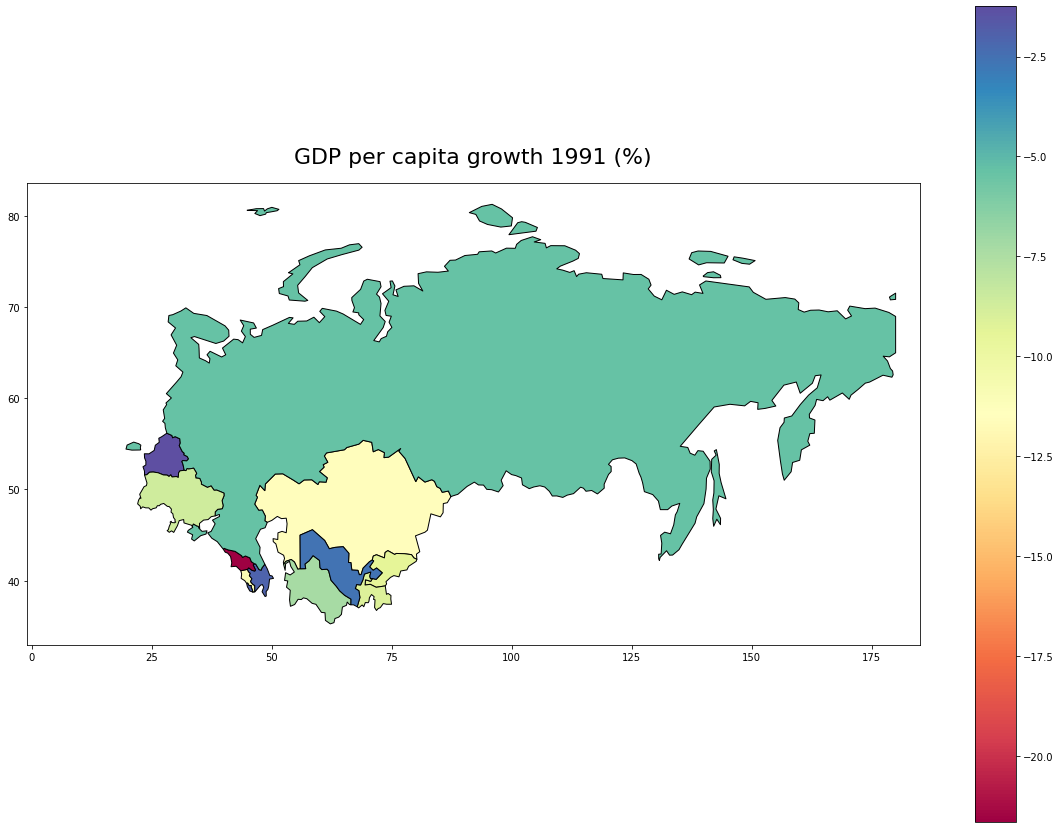

In [ ]:
#indicator for year 1991: GDP per capita growth (annual %)
#note that the Baltic countries did not have data between period 1991-1994
indi_dict = {'NY.GDP.PCAP.KD.ZG': 'data_column'}
geopand_ussr(indi_dict, 1991, 'GDP per capita growth 1991 (%)')

In [ ]:
#indicator: Population Growth Rate (%)
indi_dict = {'SP.POP.GROW': 'data_column'}
geopand_ussr(indi_dict, 1991, 'Population Growth Rate 1990 (%)')

In [ ]:
#indicator for year 1996: GDP per capita growth (annual %)
#note that the Baltic countries did not have data between period 1991-1995
indi_dict = {'NY.GDP.PCAP.KD.ZG': 'data_column'}
geopand_ussr(indi_dict, 1996, 'GDP per capita growth 1996 (%)')

In [ ]:
#indicator: Population Growth Rate (%)
indi_dict = {'SP.POP.GROW': 'data_column'}
geopand_ussr(indi_dict, 2000, 'Population Growth Rate 2000 (%)')

In [ ]:
#A function that draws a geopanda graph, accepting a query_dictionary, the year and the title as arguments
#countries_ussr = ['Armenia', 'Azerbaijan', 'Belarus', 'Estonia', 'Georgia', 'Kazakhstan', 'Kyrgyz Republic', 'Latvia', 'Lithuania', 'Moldova', 'Russia', 'Tajikistan', 'Turkmenistan', 'Ukraine', 'Uzbekistan']
#countries_iso3166 = ['ARM', 'AZE', 'BLR', 'EST', 'GEO','KAZ', 'KGZ', 'LVA', 'LTU', 'MDA', 'RUS', 'TJK', 'TKM', 'UKR', 'UZB' ]

#countries: Armenia', 'Azerbaijan', 'Belarus', 'Estonia', 'Georgia', 'Kazakhstan', 'Kyrgyz Republic', 'Latvia', 'Lithuania', 'Moldova', 'Russia', 'Tajikistan', 'Turkmenistan', 'Ukraine', 'Uzbekistan'

def geopand_ussr(indi_dict, year, title):
    countries_ussr = ['Kyrgyzstan', 'Kazakhstan', 'Russia','Tajikistan', 'Turkmenistan','Uzbekistan']
    countries_iso3166 = ['KAZ', 'KGZ','RUS','TJK', 'TKM','UZB']
    
    df = wbdata.get_dataframe(indicators=indi_dict, country=countries_iso3166)
    df.reset_index(inplace=True)
    df['date'] = df['date'].astype(int)
    df = df[df['date'] == year]
    df = df.sort_values(by=['country'])

    world = geopandas.read_file(geopandas.datasets.get_path('naturalearth_lowres'))
    world = world[world['name'].isin(countries_ussr)]
    world = world.sort_values(by=['name'])
    world['data_column'] = df['data_column'].values

    graph = world.plot('data_column', cmap='Spectral', figsize=(20,20), legend=True, legend_kwds={'shrink': 0.75}, aspect= 'auto', edgecolor= 'black')
    
    graph.set_xlim(right = 185)
    graph.set_xlim(left = -1)
    
    graph.set_title(title, size=22, pad=20);

    world.apply(lambda x: graph.annotate(text=x['name'], xy=x.geometry.centroid.coords[0], 
                                         ha='center'),axis=1);

In [ ]:
#indicator for year 1991: GDP per capita growth (annual %)
#note that the Baltic countries did not have data between period 1991-1994
indi_dict = {'NY.GDP.PCAP.KD.ZG': 'data_column'}
geopand_ussr(indi_dict, 1991, 'GDP per capita growth 1991 (%)')

In [ ]:
#A function that draws a geopanda graph, accepting a query_dictionary, the year and the title as arguments
#countries_ussr = ['Armenia', 'Azerbaijan', 'Belarus', 'Estonia', 'Georgia', 'Kazakhstan', 'Kyrgyz Republic', 'Latvia', 'Lithuania', 'Moldova', 'Russia', 'Tajikistan', 'Turkmenistan', 'Ukraine', 'Uzbekistan']
#countries_iso3166 = ['ARM', 'AZE', 'BLR', 'EST', 'GEO','KAZ', 'KGZ', 'LVA', 'LTU', 'MDA', 'RUS', 'TJK', 'TKM', 'UKR', 'UZB' ]

#countries: Armenia', 'Azerbaijan', 'Belarus', 'Estonia', 'Georgia', 'Kazakhstan', 'Kyrgyz Republic', 'Latvia', 'Lithuania', 'Moldova', 'Russia', 'Tajikistan', 'Turkmenistan', 'Ukraine', 'Uzbekistan'

def geopand_ussr(indi_dict, year, title):
    countries_ussr = ['Belarus', 'Estonia','Latvia', 'Lithuania', 'Moldova','Ukraine']
    countries_iso3166 = ['BLR', 'EST', 'LVA', 'LTU', 'MDA', 'UKR' ]
    
    df = wbdata.get_dataframe(indicators=indi_dict, country=countries_iso3166)
    df.reset_index(inplace=True)
    df['date'] = df['date'].astype(int)
    df = df[df['date'] == year]
    df = df.sort_values(by=['country'])

    world = geopandas.read_file(geopandas.datasets.get_path('naturalearth_lowres'))
    world = world[world['name'].isin(countries_ussr)]
    world = world.sort_values(by=['name'])
    world['data_column'] = df['data_column'].values

    graph = world.plot('data_column', cmap='Spectral', figsize=(15,15), legend=True, aspect= 'auto', edgecolor= 'black')
    
    graph.set_title(title, size=22, pad=20);

    world.apply(lambda x: graph.annotate(text=x['name'], xy=x.geometry.centroid.coords[0], 
                                         ha='center'),axis=1);

In [ ]:
#indicator for year 1991: GDP per capita growth (annual %)
#note that the Baltic countries & Moldova did not have data between period 1991-1994
indi_dict = {'NY.GDP.PCAP.KD.ZG': 'data_column'}
geopand_ussr(indi_dict, 1991, 'GDP per capita growth 1991 (%)')

In [ ]:
#indicator for year 1991: GDP per capita growth (annual %)
#note that the Baltic countries did not have data between period 1991-1994
indi_dict = {'NY.GDP.PCAP.KD.ZG': 'data_column'}
geopand_ussr(indi_dict, 1996, 'GDP per capita growth 1996 (%)')

In [ ]:
#indicator: Population Growth Rate (%)
indi_dict = {'SP.POP.GROW': 'data_column'}
geopand_ussr(indi_dict, 1990, 'Population Growth Rate 1990 (%)')

In [ ]:
#indicator: Population Growth Rate (%)
indi_dict = {'SP.POP.GROW': 'data_column'}
geopand_ussr(indi_dict, 1991, 'Population Growth Rate 1991 (%)')

In [ ]:
#indicator: Population Growth Rate (%)
indi_dict = {'SP.POP.GROW': 'data_column'}
geopand_ussr(indi_dict, 1995, 'Population Growth Rate 1995 (%)')

In [ ]:
#indicator: Population Growth Rate (%)
indi_dict = {'SP.POP.GROW': 'data_column'}
geopand_ussr(indi_dict, 2000, 'Population Growth Rate 2000 (%)')

In [ ]:
#countries_ussr = ['Armenia', 'Azerbaijan', 'Belarus', 'Estonia', 'Georgia', 'Kazakhstan', 'Kyrgyz Republic', 'Latvia', 'Lithuania', 'Moldova', 'Russia', 'Tajikistan', 'Turkmenistan', 'Ukraine', 'Uzbekistan']
#countries_iso3166 = ['ARM', 'AZE', 'BLR', 'EST', 'GEO','KAZ', 'KGZ', 'LVA', 'LTU', 'MDA', 'RUS', 'TJK', 'TKM', 'UKR', 'UZB' ]

#countries: Armenia', 'Azerbaijan', 'Belarus', 'Estonia', 'Georgia', 'Kazakhstan', 'Kyrgyz Republic', 'Latvia', 'Lithuania', 'Moldova', 'Russia', 'Tajikistan', 'Turkmenistan', 'Ukraine', 'Uzbekistan'

def geopand_ussr(indi_dict, year, title):
    countries_ussr = ['Armenia', 'Azerbaijan', 'Georgia']
    countries_iso3166 = ['ARM', 'AZE','GEO']
    
    df = wbdata.get_dataframe(indicators=indi_dict, country=countries_iso3166)
    df.reset_index(inplace=True)
    df['date'] = df['date'].astype(int)
    df = df[df['date'] == year]
    df = df.sort_values(by=['country'])

    world = geopandas.read_file(geopandas.datasets.get_path('naturalearth_lowres'))
    world = world[world['name'].isin(countries_ussr)]
    world = world.sort_values(by=['name'])
    world['data_column'] = df['data_column'].values

    graph = world.plot('data_column', cmap='Spectral', figsize=(20,20), legend=True, legend_kwds={'shrink': 0.75}, aspect= 'auto', edgecolor= 'black')
    
    graph.set_title(title, size=22, pad=20);

    world.apply(lambda x: graph.annotate(text=x['name'], xy=x.geometry.centroid.coords[0], 
                                         ha='center'),axis=1);

In [ ]:
#indicator for year 1991: GDP per capita growth (annual %)
#note that the Baltic countries & Moldova did not have data between period 1991-1994
indi_dict = {'NY.GDP.PCAP.KD.ZG': 'data_column'}
geopand_ussr(indi_dict, 1991, 'GDP per capita growth 1991 (%)')

In [ ]:
#indicator: Population Growth Rate (%)
indi_dict = {'SP.POP.GROW': 'data_column'}
geopand_ussr(indi_dict, 1990, 'Population Growth Rate 1990 (%)')

In [ ]:
#indicator: Population Growth Rate (%)
indi_dict = {'SP.POP.GROW': 'data_column'}
geopand_ussr(indi_dict, 1991, 'Population Growth Rate 1991 (%)')

In [ ]:
#indicator: Population Growth Rate (%)
indi_dict = {'SP.POP.GROW': 'data_column'}
geopand_ussr(indi_dict, 1995, 'Population Growth Rate 1995 (%)')

In [ ]:
#indicator: Population Growth Rate (%)
indi_dict = {'SP.POP.GROW': 'data_column'}
geopand_ussr(indi_dict, 2000, 'Population Growth Rate 2000 (%)')

In [ ]:
#A function that draws a geopanda graph, accepting a query_dictionary, the year and the title as arguments
#countries_ussr = ['Armenia', 'Azerbaijan', 'Belarus', 'Estonia', 'Georgia', 'Kazakhstan', 'Kyrgyz Republic', 'Latvia', 'Lithuania', 'Moldova', 'Russia', 'Tajikistan', 'Turkmenistan', 'Ukraine', 'Uzbekistan']
#countries_iso3166 = ['ARM', 'AZE', 'BLR', 'EST', 'GEO','KAZ', 'KGZ', 'LVA', 'LTU', 'MDA', 'RUS', 'TJK', 'TKM', 'UKR', 'UZB' ]

#countries: Armenia', 'Azerbaijan', 'Belarus', 'Estonia', 'Georgia', 'Kazakhstan', 'Kyrgyz Republic', 'Latvia', 'Lithuania', 'Moldova', 'Russia', 'Tajikistan', 'Turkmenistan', 'Ukraine', 'Uzbekistan'

def geopand_ussr(indi_dict, year, title):
    countries_ussr = ['Kyrgyzstan','Tajikistan', 'Turkmenistan','Uzbekistan']
    countries_iso3166 = ['KGZ','TJK', 'TKM','UZB']
    
    df = wbdata.get_dataframe(indicators=indi_dict, country=countries_iso3166)
    df.reset_index(inplace=True)
    df['date'] = df['date'].astype(int)
    df = df[df['date'] == year]
    df = df.sort_values(by=['country'])

    world = geopandas.read_file(geopandas.datasets.get_path('naturalearth_lowres'))
    world = world[world['name'].isin(countries_ussr)]
    world = world.sort_values(by=['name'])
    world['data_column'] = df['data_column'].values

    graph = world.plot('data_column', cmap='Spectral', figsize=(20,20), legend=True, legend_kwds={'shrink': 0.75}, aspect= 'auto', edgecolor= 'black')
    
    graph.set_title(title, size=22, pad=20);

    world.apply(lambda x: graph.annotate(text=x['name'], xy=x.geometry.centroid.coords[0], 
                                         ha='center'),axis=1)

In [ ]:
#indicator: Population Growth Rate (%)
indi_dict = {'SP.POP.GROW': 'data_column'}
geopand_ussr(indi_dict, 1990, 'Population Growth Rate 1990 (%)')

In [ ]:
#indicator: Population Growth Rate (%)
indi_dict = {'SP.POP.GROW': 'data_column'}
geopand_ussr(indi_dict, 1991, 'Population Growth Rate 1991 (%)')

In [ ]:
#indicator: Population Growth Rate (%)
indi_dict = {'SP.POP.GROW': 'data_column'}
geopand_ussr(indi_dict, 1995, 'Population Growth Rate 1995 (%)')

In [ ]:
#indicator: Population Growth Rate (%)
indi_dict = {'SP.POP.GROW': 'data_column'}
geopand_ussr(indi_dict, 2000, 'Population Growth Rate 2000 (%)')

In [ ]:
#A function that draws a geopanda graph, accepting a query_dictionary, the year and the title as arguments
#countries_ussr = ['Armenia', 'Azerbaijan', 'Belarus', 'Estonia', 'Georgia', 'Kazakhstan', 'Kyrgyz Republic', 'Latvia', 'Lithuania', 'Moldova', 'Russia', 'Tajikistan', 'Turkmenistan', 'Ukraine', 'Uzbekistan']
#countries_iso3166 = ['ARM', 'AZE', 'BLR', 'EST', 'GEO','KAZ', 'KGZ', 'LVA', 'LTU', 'MDA', 'RUS', 'TJK', 'TKM', 'UKR', 'UZB' ]

#countries: Armenia', 'Azerbaijan', 'Belarus', 'Estonia', 'Georgia', 'Kazakhstan', 'Kyrgyz Republic', 'Latvia', 'Lithuania', 'Moldova', 'Russia', 'Tajikistan', 'Turkmenistan', 'Ukraine', 'Uzbekistan'

def geopand_ussr(indi_dict, year, title):
    countries_ussr = ['Kazakhstan', 'Russia']
    countries_iso3166 = ['KAZ','RUS']
    
    df = wbdata.get_dataframe(indicators=indi_dict, country=countries_iso3166)
    df.reset_index(inplace=True)
    df['date'] = df['date'].astype(int)
    df = df[df['date'] == year]
    df = df.sort_values(by=['country'])

    world = geopandas.read_file(geopandas.datasets.get_path('naturalearth_lowres'))
    world = world[world['name'].isin(countries_ussr)]
    world = world.sort_values(by=['name'])
    world['data_column'] = df['data_column'].values

    graph = world.plot('data_column', cmap='Spectral', figsize=(20,20), legend=True, legend_kwds={'shrink': 0.75}, aspect= 'auto', edgecolor= 'black')
    
    graph.set_xlim(right = 185)
    graph.set_xlim(left = -1)
    
    graph.set_title(title, size=22, pad=20);

    world.apply(lambda x: graph.annotate(text=x['name'], xy=x.geometry.centroid.coords[0], 
                                         ha='center'),axis=1)

In [ ]:
#indicator: Population Growth Rate (%)
indi_dict = {'SP.POP.GROW': 'data_column'}
geopand_ussr(indi_dict, 1990, 'Population Growth Rate 1990 (%)')

In [ ]:
#indicator: Population Growth Rate (%)
indi_dict = {'SP.POP.GROW': 'data_column'}
geopand_ussr(indi_dict, 1991, 'Population Growth Rate 1991 (%)')

In [ ]:
#indicator: Population Growth Rate (%)
indi_dict = {'SP.POP.GROW': 'data_column'}
geopand_ussr(indi_dict, 1995, 'Population Growth Rate 1995 (%)')

In [ ]:
#indicator: Population Growth Rate (%)
indi_dict = {'SP.POP.GROW': 'data_column'}
geopand_ussr(indi_dict, 2000, 'Population Growth Rate 2000 (%)')

[C] Other Visualisations - Population & Demographics

In [ ]:
#Population over Time (Eastern Europe)
variable_labels = {"SP.POP.TOTL":"Population"}

# Three letter codes come from wbdata.get_country()
countries = {"BLR":"Belarus",
             "MDA":"Moldova",
             "RUS":"Russian Federation",
             "UKR":"Ukraine",
             "WLD":"World"
            }

df = wbdata.get_dataframe(variable_labels, country = countries).squeeze()

df = df.unstack('country')
# Date index is of type string; change to integers
df.index = df.index.astype(int)

# Differences (over time) in logs give us growth rates
new_df = np.log(df).diff()

# Useful arguments to pass include xTitle, yTitle, Title
#Using a small subset of former Soviet Countries with the horizontal line representing the fall of the Soviet Union
fig, ax = plt.subplots()
sns.lineplot(data=new_df, x="date", y="Belarus", 
             label = 'Belarus', color='orange', linewidth=1.5, dashes=(5, 1), ax = ax)
sns.lineplot(data=new_df, x="date", y="Moldova", 
             label = 'Moldova', color='blue', linewidth=1.5, ax = ax)
sns.lineplot(data=new_df, x="date", y="Russian Federation", 
             label = 'Russia', color='purple', linewidth=1.5, ax = ax)
sns.lineplot(data=new_df, x="date", y="Ukraine", 
             label = 'Ukraine', color='cyan', linewidth=1.5, ax = ax)
sns.lineplot(data=new_df, x="date", y="World", 
             label = 'World', color='black', linewidth=2.5, ax = ax)
plt.axvline(x = 1991, color = 'red', linestyle = '--')
ax.set(xlabel='Year', ylabel='Growth Rate');

In [ ]:
#Population over Time (Baltics)
variable_labels = {"SP.POP.TOTL":"Population"}

# Three letter codes come from wbdata.get_country()
countries = {"EST":"Estonia",
             "LTU":"Lithuania",
             "LVA":"Latvia",
             "WLD":"World"
            }

df = wbdata.get_dataframe(variable_labels, country = countries).squeeze()

df = df.unstack('country')
# Date index is of type string; change to integers
df.index = df.index.astype(int)

# Differences (over time) in logs give us growth rates
new_df = np.log(df).diff()

# Useful arguments to pass include xTitle, yTitle, Title
#Using a small subset of former Soviet Countries with the horizontal line representing the fall of the Soviet Union
fig, ax = plt.subplots()
sns.lineplot(data=new_df, x="date", y="Estonia", 
             label = 'Estonia', color='green', linewidth=1.5, ax = ax)
sns.lineplot(data=new_df, x="date", y="Latvia", 
             label = 'Latvia', color='purple', linewidth=1.5, ax = ax)
sns.lineplot(data=new_df, x="date", y="Lithuania", 
             label = 'Lithuania', color='cyan', linewidth=1.5, ax = ax)
sns.lineplot(data=new_df, x="date", y="World", 
             label = 'World', color='black', linewidth=2.5, ax = ax)
plt.axvline(x = 1991, color = 'red', linestyle = '--')
ax.set(xlabel='Year', ylabel='Growth Rate');

In [ ]:
#Population over Time (Caucasus)
variable_labels = {"SP.POP.TOTL":"Population"}

# Three letter codes come from wbdata.get_country()
countries = {"ARM":"Armenia",
             "AZE":"Azerbaijan",
             "GEO":"Georgia",
             "WLD":"World"
            }

df = wbdata.get_dataframe(variable_labels, country = countries).squeeze()

df = df.unstack('country')
# Date index is of type string; change to integers
df.index = df.index.astype(int)

# Differences (over time) in logs give us growth rates
new_df = np.log(df).diff()

# Useful arguments to pass include xTitle, yTitle, Title
#Using a small subset of former Soviet Countries with the horizontal line representing the fall of the Soviet Union
fig, ax = plt.subplots()
sns.lineplot(data=new_df, x="date", y="Armenia", 
             label = 'Armenia', color='purple', linewidth=1.5, ax = ax)
sns.lineplot(data=new_df, x="date", y="Azerbaijan", 
             label = 'Azerbaijan', color='green', linewidth=1.5, ax = ax)
sns.lineplot(data=new_df, x="date", y="Georgia", 
             label = 'Georgia', color='cyan', linewidth=1.5, ax = ax)
sns.lineplot(data=new_df, x="date", y="World", 
             label = 'World', color='black', linewidth=2.5, ax = ax)
plt.axvline(x = 1991, color = 'red', linestyle = '--')
ax.set(xlabel='Year', ylabel='Growth Rate');

In [ ]:
#Population over Time (Central Asia)
variable_labels = {"SP.POP.TOTL":"Population"}

# Three letter codes come from wbdata.get_country()
countries = {"KAZ":"Kazakhstan",
             "KGZ":"Kyrgyzstan",
             "TJK":"Tajikistan",
             "TKM":"Turkmenistan",
             "UZB":"Uzbekistan",
             "WLD":"World"
            }

df = wbdata.get_dataframe(variable_labels, country = countries).squeeze()

df = df.unstack('country')
# Date index is of type string; change to integers
df.index = df.index.astype(int)

# Differences (over time) in logs give us growth rates
new_df = np.log(df).diff()

# Useful arguments to pass include xTitle, yTitle, Title
#Using a small subset of former Soviet Countries with the horizontal line representing the fall of the Soviet Union
fig, ax = plt.subplots()
sns.lineplot(data=new_df, x="date", y="Kazakhstan", 
             label = 'Kazakhstan', color='red', linewidth=1.5, dashes=(5, 1), ax = ax)
sns.lineplot(data=new_df, x="date", y="Kyrgyz Republic", 
             label = 'Kyrgyz Republic', color='blue', linewidth=1.5, ax = ax)
sns.lineplot(data=new_df, x="date", y="Tajikistan", 
             label = 'Tajikistan', color='purple', linewidth=1.5, ax = ax)
sns.lineplot(data=new_df, x="date", y="Turkmenistan", 
             label = 'Turkmenistan', color='orange', linewidth=1.5, ax = ax)
sns.lineplot(data=new_df, x="date", y="Uzbekistan", 
             label = 'Uzbekistan', color='cyan', linewidth=1.5, ax = ax)
sns.lineplot(data=new_df, x="date", y="World", 
             label = 'World', color='black', linewidth=2.5, ax = ax)
plt.axvline(x = 1991, color = 'red', linestyle = '--')
ax.set(xlabel='Year', ylabel='Growth Rate');

In [ ]:
#Select Countries Compared to the World: Deeper Look at Some Countries' Demographics
variable_labels = {"SP.POP.TOTL":"Population"}

# Three letter codes come from wbdata.get_country()
countries = {"KAZ":"Kazakhstan",
             "WLD":"World"
            }

df = wbdata.get_dataframe(variable_labels, country = countries).squeeze()

df = df.unstack('country')
# Date index is of type string; change to integers
df.index = df.index.astype(int)

# Differences (over time) in logs give us growth rates
new_df = np.log(df).diff()

# Useful arguments to pass include xTitle, yTitle, Title
#Using a small subset of former Soviet Countries with the horizontal line representing the fall of the Soviet Union
fig, ax = plt.subplots()
sns.lineplot(data=new_df, x="date", y="Kazakhstan", 
             label = 'Kazakhstan', color='red', linewidth=1.5, dashes=(5, 1), ax = ax)
sns.lineplot(data=new_df, x="date", y="World", 
             label = 'World', color='black', linewidth=2.5, ax = ax)
plt.axvline(x = 1991, color = 'red', linestyle = '--')
ax.set(xlabel='Year', ylabel='Growth Rate');

In [ ]:
#Select Countries Compared to the World: Deeper Look at Some Countries' Demographics
variable_labels = {"SP.POP.TOTL":"Population"}

# Three letter codes come from wbdata.get_country()
countries = {"KGZ":"Kyrgyzstan",
             "WLD":"World"
            }

df = wbdata.get_dataframe(variable_labels, country = countries).squeeze()

df = df.unstack('country')
# Date index is of type string; change to integers
df.index = df.index.astype(int)

# Differences (over time) in logs give us growth rates
new_df = np.log(df).diff()

# Useful arguments to pass include xTitle, yTitle, Title
#Using a small subset of former Soviet Countries with the horizontal line representing the fall of the Soviet Union
fig, ax = plt.subplots()
sns.lineplot(data=new_df, x="date", y="Kyrgyz Republic", 
             label = 'Kyrgyz Republic', color='blue', linewidth=1.5, ax = ax)
sns.lineplot(data=new_df, x="date", y="World", 
             label = 'World', color='black', linewidth=2.5, ax = ax)
plt.axvline(x = 1991, color = 'red', linestyle = '--')
ax.set(xlabel='Year', ylabel='Growth Rate');

In [ ]:
#Select Countries Compared to the World: Deeper Look at Some Countries' Demographics
variable_labels = {"SP.POP.TOTL":"Population"}

# Three letter codes come from wbdata.get_country()
countries = {"RUS":"Russian Federation",
             "WLD":"World"
            }

df = wbdata.get_dataframe(variable_labels, country = countries).squeeze()

df = df.unstack('country')
# Date index is of type string; change to integers
df.index = df.index.astype(int)

# Differences (over time) in logs give us growth rates
new_df = np.log(df).diff()

# Useful arguments to pass include xTitle, yTitle, Title
#Using a small subset of former Soviet Countries with the horizontal line representing the fall of the Soviet Union
fig, ax = plt.subplots()
sns.lineplot(data=new_df, x="date", y="Russian Federation", 
             label = 'Russia', color='blue', linewidth=1.5, ax = ax)
sns.lineplot(data=new_df, x="date", y="World", 
             label = 'World', color='black', linewidth=2.5, ax = ax)
plt.axvline(x = 1991, color = 'red', linestyle = '--')
ax.set(xlabel='Year', ylabel='Growth Rate');

In [ ]:
#Select Countries Compared to the World: Deeper Look at Some Countries' Demographics
variable_labels = {"SP.POP.TOTL":"Population"}

# Three letter codes come from wbdata.get_country()
countries = {"GEO":"Georgia",
             "WLD":"World"
            }

df = wbdata.get_dataframe(variable_labels, country = countries).squeeze()

df = df.unstack('country')
# Date index is of type string; change to integers
df.index = df.index.astype(int)

# Differences (over time) in logs give us growth rates
new_df = np.log(df).diff()

# Useful arguments to pass include xTitle, yTitle, Title
#Using a small subset of former Soviet Countries with the horizontal line representing the fall of the Soviet Union
fig, ax = plt.subplots()
sns.lineplot(data=new_df, x="date", y="Georgia", 
             label = 'Georgia', color='blue', linewidth=1.5, ax = ax)
sns.lineplot(data=new_df, x="date", y="World", 
             label = 'World', color='black', linewidth=2.5, ax = ax)
plt.axvline(x = 1991, color = 'red', linestyle = '--')
ax.set(xlabel='Year', ylabel='Growth Rate');

In [ ]:
#Select Countries Compared to the World: Deeper Look at Some Countries' Demographics
variable_labels = {"SP.POP.TOTL":"Population"}

# Three letter codes come from wbdata.get_country()
countries = {"AZE":"Azerbaijan",
             "WLD":"World"
            }

df = wbdata.get_dataframe(variable_labels, country = countries).squeeze()

df = df.unstack('country')
# Date index is of type string; change to integers
df.index = df.index.astype(int)

# Differences (over time) in logs give us growth rates
new_df = np.log(df).diff()

# Useful arguments to pass include xTitle, yTitle, Title
#Using a small subset of former Soviet Countries with the horizontal line representing the fall of the Soviet Union
fig, ax = plt.subplots()
sns.lineplot(data=new_df, x="date", y="Azerbaijan", 
             label = 'Azerbaijan', color='pink', linewidth=1.5, dashes=(5, 1), ax = ax)
sns.lineplot(data=new_df, x="date", y="World", 
             label = 'World', color='black', linewidth=2.5, ax = ax)
plt.axvline(x = 1991, color = 'red', linestyle = '--')
ax.set(xlabel='Year', ylabel='Growth Rate');

In [ ]:
#GDP over Time (Caucasus)
variable_labels = {"NY.GDP.PCAP.KD.ZG":"GDP Over Time"}

# Three letter codes come from wbdata.get_country()
countries = {"ARM":"Armenia",
             "AZE":"Azerbaijan",
             "GEO":"Georgia",
             "WLD":"World"
            }

df = wbdata.get_dataframe(variable_labels, country = countries).squeeze()

df = df.unstack('country')
# Date index is of type string; change to integers
df.index = df.index.astype(int)

# Differences (over time) in logs give us growth rates
new_df = np.log(df).diff()

# Useful arguments to pass include xTitle, yTitle, Title
#Using a small subset of former Soviet Countries with the horizontal line representing the fall of the Soviet Union
fig, ax = plt.subplots()
sns.lineplot(data=new_df, x="date", y="Armenia", 
             label = 'Armenia', color='purple', linewidth=1.5, ax = ax)
sns.lineplot(data=new_df, x="date", y="Azerbaijan", 
             label = 'Azerbaijan', color='green', linewidth=1.5, ax = ax)
sns.lineplot(data=new_df, x="date", y="Georgia", 
             label = 'Georgia', color='cyan', linewidth=1.5, ax = ax)
sns.lineplot(data=new_df, x="date", y="World", 
             label = 'World', color='black', linewidth=2.5, ax = ax)
plt.axvline(x = 1991, color = 'red', linestyle = '--')
ax.set(xlabel='Year', ylabel='Growth Rate');

In [ ]:
#agricultural supply list
!pip install eep153_tools
!pip install python_gnupg
#from eep153_tools.sheets import decrypt_credentials
#decrypt_credentials('../students.json.gpg')

In [ ]:
!ls ~/.eep153.service_accounts/

In [ ]:
from eep153_tools.sheets import read_sheets
#getting data for aggircultural data
#### Read a bunch of google worksheets into a dictionary of dataframes
data = read_sheets('https://docs.google.com/spreadsheets/d/1DLn9owcS7ggojJGWlI9vKSz0hqozn6cbcqNGWgzMZ8k',force_numeric=False)

data.keys()

In [ ]:
#creating a dataframe with the agricultural factors included
import pandas as pd

def get_international_ag_productivity_data(series):

    columns=series.iloc[1,:]  # Need to fix columns
    series = series.iloc[2:,:]
    series.columns = columns

    # Set index to country code
    series = series.set_index('WDI Code')

    series = series[['%d' % t for t in range(1961,2020)]]

    series = series.replace({',':''},regex=True) # Get rid of commas in number strings
    series = series.replace({'':'NaN'}) # Change empty cells to NaN strings
    series = series.apply(lambda x: pd.to_numeric(x,errors='ignore'))
    series = series.astype(float) # Convert to floats

    series = series.stack()
    
    series = series.loc[~series.index.duplicated(keep='first')] 

    series.index.names = ['WDI Code','Year']

    return series
   

Data = ['Output','Ag TFP','Ag Land','Irrig','Pasture','Labor','Livestock',
        'Machinery','Fertilizer','Feed']

D = {}
for key in Data:
    D[key] = get_international_ag_productivity_data(data[key])
countries = {"WLD":"World"
            }
#Choosing world data and reformating it for later dataframe concatanation 
growth_ag = pd.DataFrame(D)
growth_ag = growth_ag.reset_index()
growth_ag = growth_ag[growth_ag['WDI Code'].isin(['WLD'])]
growth_ag['date'] = growth_ag['Year']
growth_ag['date'] = growth_ag['date'].astype(int)
growth_ag = growth_ag[growth_ag['date'] < 2015]
growth_ag = growth_ag[growth_ag['date'] > 1980]
growth_ag['country'] = growth_ag['WDI Code']
growth_ag = growth_ag.drop(columns = ['Year','WDI Code'])
growth_ag = growth_ag.replace({"country": countries})
growth_ag = growth_ag.set_index(['country','date'])
growth_ag

In [ ]:
#creating a dataframe with population growth rate data
df = wbdata.get_dataframe(variable_labels, country = countries)
growth_rates = np.log(df).diff()
growth_rates = growth_rates.reset_index()
#reformating for later concatanation
growth_rates = growth_rates[growth_rates['country'].isin(['World'])]
growth_rates['date'] = growth_rates['date'].astype(int)
growth_rates = growth_rates[growth_rates['date'] < 2015]
growth_rates = growth_rates[growth_rates['date'] > 1980]
growth_rates = growth_rates.set_index(['country','date'])
growth_rates

In [ ]:
#getting correlation, importantly includes correlation between total agricultural output and population growth rate
ag_growth = pd.concat([growth_ag,growth_rates],axis = 1)
ag_growth.corr()

In [ ]:
#agricultural factor correlation among soviet union countries
ag.corr()

In [ ]:
#georgia/usa machinery graph
import pandas as pd

def get_international_ag_productivity_data(series):

    columns=series.iloc[1,:]  # Need to fix columns
    series = series.iloc[2:,:]
    series.columns = columns

    # Set index to country code
    series = series.set_index('WDI Code')

    series = series[['%d' % t for t in range(1961,2020)]]

    series = series.replace({',':''},regex=True) # Get rid of commas in number strings
    series = series.replace({'':'NaN'}) # Change empty cells to NaN strings
    series = series.apply(lambda x: pd.to_numeric(x,errors='ignore'))
    series = series.astype(float) # Convert to floats

    series = series.stack()
    
    series = series.loc[~series.index.duplicated(keep='first')] 

    series.index.names = ['WDI Code','Year']

    return series
   

Data = ['Output','Ag TFP','Ag Land','Irrig','Pasture','Labor','Livestock',
        'Machinery','Fertilizer','Feed']

D = {}
for key in Data:
    D[key] = get_international_ag_productivity_data(data[key])

comp = pd.DataFrame(D)
comp = comp.reset_index()
comp = comp[comp['WDI Code'].isin(['RUS','GEO'])]
comp = comp[comp['Year'].astype(int) > 1985]
comp = comp.set_index('WDI Code')
comp

In [ ]:
#graphing machinery data for Russia and Georgia
comp = comp.reset_index()
comp = comp[['Year','Machinery','WDI Code']]
comp['Year'] = comp['Year'].astype(int)
fig, ax = plt.subplots(figsize=(18,6))
for name, group in comp.groupby('WDI Code'):
    group.plot(x= 'Year', y='Machinery', ax=ax, label=name,title = 'Machinery')
plt.axvline(x = 1991, color = 'red', linestyle = '--')
plt.show()

In [ ]:
#graphing labor data for Russia and Georgia
comp = comp.reset_index()
comp = comp[['Year','Labor','WDI Code']]
comp['Year'] = comp['Year'].astype(int)
fig, ax = plt.subplots(figsize=(18,6))
for name, group in comp.groupby('WDI Code'):
    group.plot(x= 'Year', y='Labor', ax=ax, label=name,title = 'Labor')
plt.axvline(x = 1991, color = 'red', linestyle = '--')
plt.show()

In [ ]:
#georgia/usa machinery graph
import pandas as pd

def get_international_ag_productivity_data(series):

    columns=series.iloc[1,:]  # Need to fix columns
    series = series.iloc[2:,:]
    series.columns = columns

    # Set index to country code
    series = series.set_index('WDI Code')

    series = series[['%d' % t for t in range(1961,2020)]]

    series = series.replace({',':''},regex=True) # Get rid of commas in number strings
    series = series.replace({'':'NaN'}) # Change empty cells to NaN strings
    series = series.apply(lambda x: pd.to_numeric(x,errors='ignore'))
    series = series.astype(float) # Convert to floats

    series = series.stack()
    
    series = series.loc[~series.index.duplicated(keep='first')] 

    series.index.names = ['WDI Code','Year']

    return series
   

Data = ['Output','Ag TFP','Ag Land','Irrig','Pasture','Labor','Livestock',
        'Machinery','Fertilizer','Feed']

D = {}
for key in Data:
    D[key] = get_international_ag_productivity_data(data[key])

comp = pd.DataFrame(D)
comp = comp.reset_index()
comp = comp[comp['WDI Code'].isin(['USA','GEO'])]
comp = comp[comp['Year'].astype(int) > 1985]
comp = comp.set_index('WDI Code')
comp

In [ ]:
#graphing machinery for USA and Georgia
comp = comp.reset_index()
comp = comp[['Year','Machinery','WDI Code']]
comp['Year'] = comp['Year'].astype(int)
fig, ax = plt.subplots(figsize=(18,6))
for name, group in comp.groupby('WDI Code'):
    group.plot(x= 'Year', y='Machinery', ax=ax, label=name,title = 'Machinery')
plt.axvline(x = 1991, color = 'red', linestyle = '--')
plt.show()

In [ ]:
#graphing labor for USA and Georgia
comp = comp.reset_index()
comp = comp[['Year','Labor','WDI Code']]
comp['Year'] = comp['Year'].astype(int)
fig, ax = plt.subplots(figsize=(18,6))
for name, group in comp.groupby('WDI Code'):
    group.plot(x= 'Year', y='Labor', ax=ax, label=name,title = 'Labor')
plt.axvline(x = 1991, color = 'red', linestyle = '--')
plt.show()

In [ ]:
#getting aggricultural dataframe for only Uzbekistan and Georgia
import pandas as pd

def get_international_ag_productivity_data(series):

    columns=series.iloc[1,:]  # Need to fix columns
    series = series.iloc[2:,:]
    series.columns = columns

    # Set index to country code
    series = series.set_index('WDI Code')

    series = series[['%d' % t for t in range(1961,2020)]]

    series = series.replace({',':''},regex=True) # Get rid of commas in number strings
    series = series.replace({'':'NaN'}) # Change empty cells to NaN strings
    series = series.apply(lambda x: pd.to_numeric(x,errors='ignore'))
    series = series.astype(float) # Convert to floats

    series = series.stack()
    
    series = series.loc[~series.index.duplicated(keep='first')] 

    series.index.names = ['WDI Code','Year']

    return series
   

Data = ['Output','Ag TFP','Ag Land','Irrig','Pasture','Labor','Livestock',
        'Machinery','Fertilizer','Feed']

D = {}
for key in Data:
    D[key] = get_international_ag_productivity_data(data[key])

comp = pd.DataFrame(D)
comp = comp.reset_index()
comp = comp[comp['WDI Code'].isin(['UZB','GEO'])]
comp = comp[comp['Year'].astype(int) > 1985]
comp = comp.set_index('WDI Code')
comp

In [ ]:
#graphing machinery for Uzbekistan and Georgia
comp = comp.reset_index()
comp = comp[['Year','Machinery','WDI Code']]
comp['Year'] = comp['Year'].astype(int)
fig, ax = plt.subplots(figsize=(18,6))
for name, group in comp.groupby('WDI Code'):
    group.plot(x= 'Year', y='Machinery', ax=ax, label=name,title = 'Machinery')
plt.axvline(x = 1991, color = 'red', linestyle = '--')
plt.show()

In [ ]:
#graphing labor for Uzbekistan and Georgia
comp = comp.reset_index()
comp = comp[['Year','Labor','WDI Code']]
comp['Year'] = comp['Year'].astype(int)
fig, ax = plt.subplots(figsize=(18,6))
for name, group in comp.groupby('WDI Code'):
    group.plot(x= 'Year', y='Labor', ax=ax, label=name,title = 'Labor')
plt.axvline(x = 1991, color = 'red', linestyle = '--')
plt.show()